In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

In [24]:
from fsd_path_planning.demo.json_demo import load_data_json
from pathlib import Path


data = list(zip(*load_data_json(Path('fsd_path_planning/demo/october_gatow_3.json'), remove_color_info=True)))
# data = list(zip(*load_data_json(Path('fsd_path_planning/demo/fss_19_4_laps.json'), remove_color_info=False)))
# data = list(zip(*load_data_json(remove_color_info=True)))
print(len(data))

1936


In [4]:
from fsd_path_planning import MissionTypes, PathPlanner
from fsd_path_planning.sorting_cones.trace_sorter.core_trace_sorter import TraceSorter



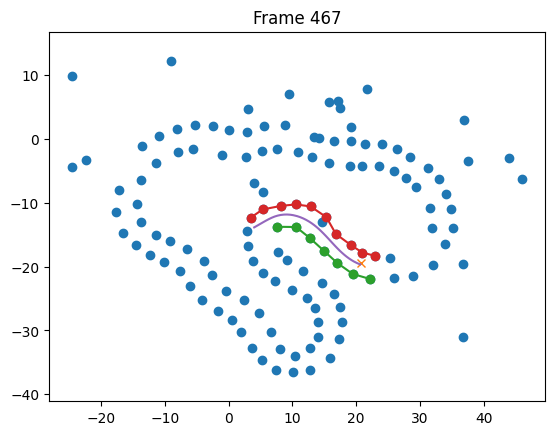

In [42]:

frame = 1243
frame = 181

# TOOD: october_gatow_3.json frame 490
# ΤΟDO: october_gatow.json frame 330

start_frame = 467
end_frame = 0

if end_frame <= start_frame:
    end_frame = start_frame + 1

for i in range(start_frame, end_frame):

    planner = PathPlanner(MissionTypes.trackdrive)

    car_position, car_direction, cones = data[i]

    out = planner.calculate_path_in_global_frame(
        cones,
        car_position,
        car_direction,
        return_intermediate_results=True,
    )

    # %timeit planner.calculate_path_in_global_frame(cones,car_position,car_direction,return_intermediate_results=True)
    # assert isinstance(out, tuple)

    (
        final_path,
        sorted_left,
        sorted_right,
        left_cones_with_virtual,
        right_cones_with_virtual,
        left_to_right_match,
        right_to_left_match,
    ) = out

    all_cones = np.row_stack(cones)

    plt.plot(all_cones[:, 0], all_cones[:, 1], 'o')
    plt.plot(car_position[0], car_position[1], 'x')
    plt.plot(*sorted_left.T, 'o-')
    plt.plot(*sorted_right.T, 'o-')
    # plt.plot(*left_cones_with_virtual.T, 'o-')
    # plt.plot(*right_cones_with_virtual.T, 'o-')
    plt.plot(*final_path[:,1:3].T, '-')
    plt.axis('equal')
    plt.title(f'Frame {i}')
    plt.show()



{'max_n_neighbors': 5, 'max_dist': 6.5, 'max_dist_to_first': 6.0, 'max_length': 11, 'threshold_directional_angle': 0.6981317007977318, 'threshold_absolute_angle': 1.1344640137963142, 'use_unknown_cones': True}


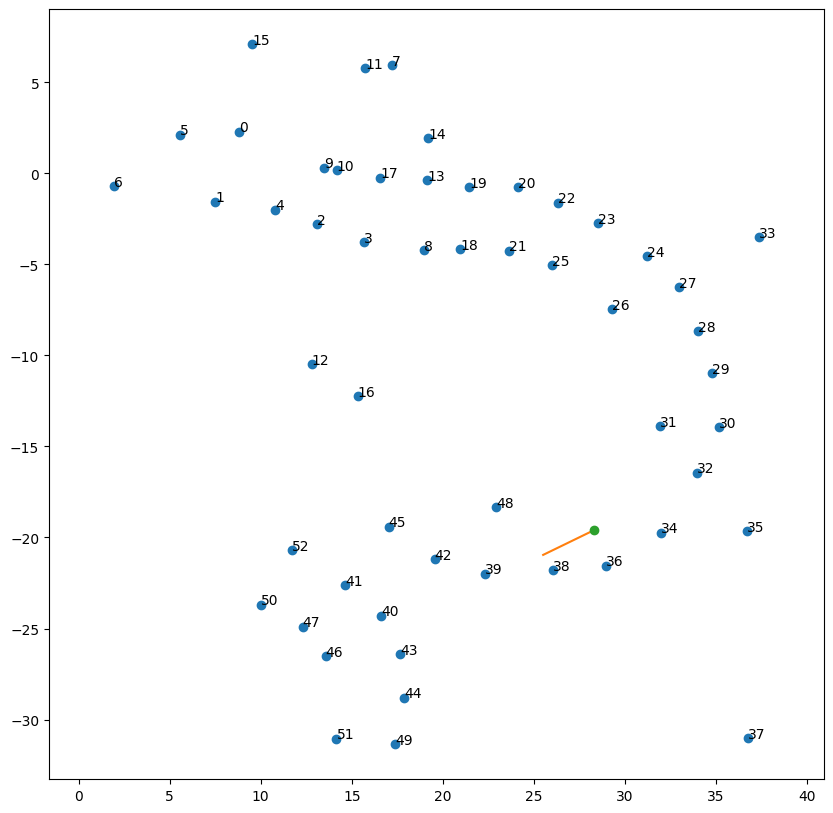

3 3


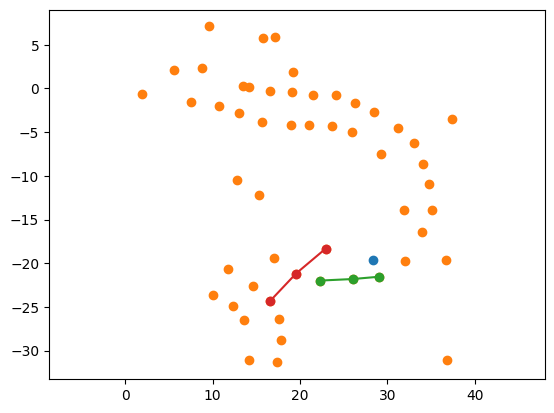

In [38]:
from fsd_path_planning.config import get_cone_sorting_config
from fsd_path_planning import ConeTypes

c = get_cone_sorting_config(MissionTypes.trackdrive)
print(c)
c1 = c.copy()
del c1['use_unknown_cones']

ts = TraceSorter(**c1)

cones_flat = ts.flatten_cones_by_type_array(cones)

mask_keep = np.ones(len(cones_flat), dtype=bool)
# mask_keep[17] = False

cones_flat = cones_flat[mask_keep]
plt.figure(figsize=(10,10))
plt.plot(cones_flat[:, 0], cones_flat[:, 1], "o")

car_end = car_position + car_direction * 3.1
car_s = np.array([car_position, car_end])
plt.plot(*car_s.T, "-")
plt.plot(*car_position, "o")
for i, cone in enumerate(cones_flat):
    plt.text(cone[0], cone[1], str(i))

plt.axis("equal")
plt.show()

# start_idx = ts.select_first_k_starting_cones(car_position, car_direction, cones_flat, ConeTypes.RIGHT)
plt.plot(car_position[0], car_position[1], "o")

l,r = ts.sort_left_right(cones, car_position, car_direction)
# %timeit ts.sort_left_right(cones, car_position, car_direction)
plt.plot(cones_flat[:, 0], cones_flat[:, 1], "o")
# plt.plot(cones_flat[start_idx, 0], cones_flat[start_idx, 1], "o-")
# plt.plot(car_position[0], car_position[1], "o")
plt.plot(*l.T, "o-")
plt.plot(*r.T, "o-")
plt.axis("equal")

print(len(l), len(r))

In [139]:
from itertools import combinations

# a = np.arange(50).reshape(10,5)
# a[3] = np.arange(a.shape[1])
# a[[0,1],-1] = -1
a = np.arange(10)[None]

print(a)

are_equal_mask = a[:,None] == a

are_minus_1_mask = a == -1
are_equal_mask = are_equal_mask | are_minus_1_mask

is_duplicate = are_equal_mask.all(axis=-1).sum(axis=0) > 1
is_duplicate

[[0 1 2 3 4 5 6 7 8 9]]


array([False])

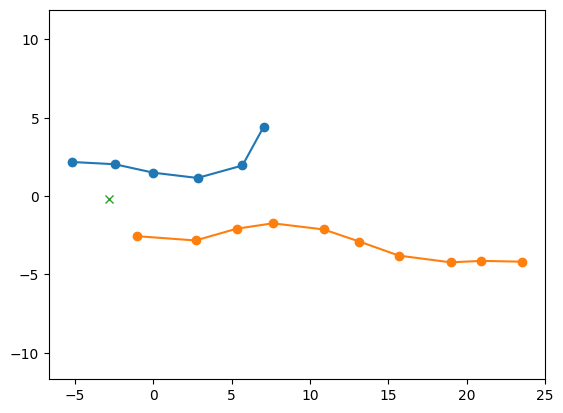

[162.39337788 159.85533929 146.60709999  17.21796608  73.44447264
 168.1786246  179.06984014 167.75073208 169.8496284  176.05388395]
[170.63475762 174.42162984 157.69813051 134.28991921  79.55634966
 159.05580359 178.11790717 167.09045612 169.45082785 175.54114617]


(-6.815897139917956, 25.073274581101092, -4.55044183, 2.4951866500000004)

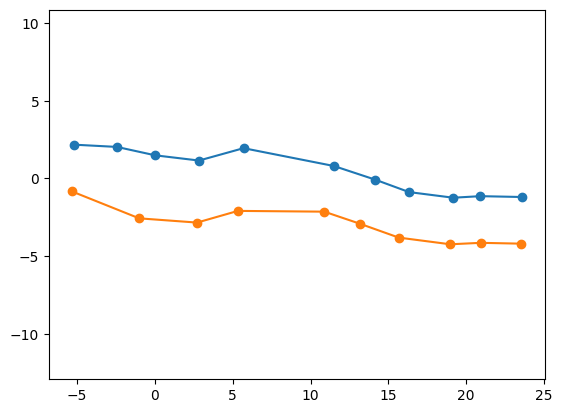

In [51]:
from fsd_path_planning.config import create_default_cone_matching_with_non_monotonic_matches
from fsd_path_planning.cone_matching.core_cone_matching import ConeMatchingState
from numpy import array

m = create_default_cone_matching_with_non_monotonic_matches(4)

state = ConeMatchingState(min_track_width=3, max_search_range=5, max_search_angle=0.8726646259971648, matches_should_be_monotonic=False, sorted_left=array([[-5.20930004,  2.17493081],
       [-2.44987106,  2.03024006],
       [ 0.0198734 ,  1.48873162],
       [ 2.8299098 ,  1.15423059],
       [ 5.69535446,  1.94961262],
       [ 7.0578537 ,  4.43040133]]), sorted_right=array([[-1.01604104, -2.56143904],
       [ 2.70356989, -2.83450651],
       [ 5.33292341, -2.0832355 ],
       [ 7.63778877, -1.7402972 ],
       [10.88364601, -2.13238001],
       [13.16276741, -2.90422082],
       [15.67347813, -3.80018067],
       [18.98889732, -4.23018599],
       [20.94279289, -4.13597679],
       [23.56168938, -4.19017982]]))


state.position_global = array([-2.79935072, -0.16019239])
state.direction_global = array([ 0.99666242, -0.08163346])
m.state = state

plt.plot(*state.sorted_left.T, 'o-')
plt.plot(*state.sorted_right.T, 'o-')
plt.plot(state.position_global[0], state.position_global[1], 'x')
plt.axis('equal')
plt.show()


out = m.run_cone_matching()
left_w_virtual, right_w_virtual, left_to_right_match, right_to_left_match = out
left_w_virtual
plt.plot(*left_w_virtual.T, 'o-')
plt.plot(*right_w_virtual.T, 'o-')
plt.axis('equal')

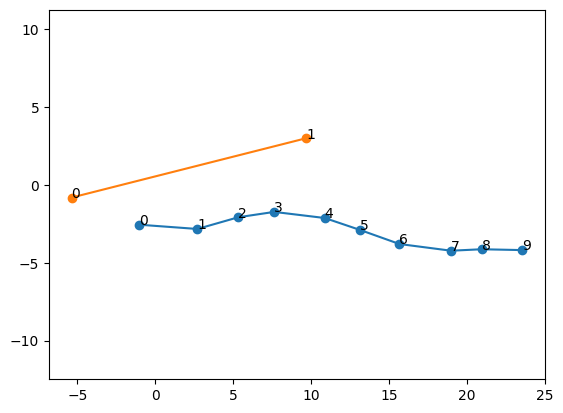

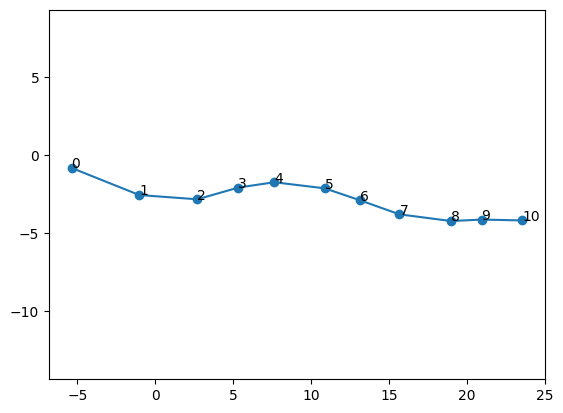

In [44]:
from fsd_path_planning.cone_matching.functional_cone_matching import insert_virtual_cones_to_existing

kwargs = {'other_side_cones': array([[-1.01604104, -2.56143904],
       [ 2.70356989, -2.83450651],
       [ 5.33292341, -2.0832355 ],
       [ 7.63778877, -1.7402972 ],
       [10.88364601, -2.13238001],
       [13.16276741, -2.90422082],
       [15.67347813, -3.80018067],
       [18.98889732, -4.23018599],
       [20.94279289, -4.13597679],
       [23.56168938, -4.19017982]]), 'other_side_virtual_cones': array([[-5.36638933, -0.82095353],
       [ 9.68736682,  2.98621964]]), 'car_position': array([-2.79935072, -0.16019239])}

osc = kwargs['other_side_cones']

plt.plot(*osc.T, 'o-')
for i in range(len(osc)):
    plt.annotate(i, osc[i])

osvc = kwargs['other_side_virtual_cones']
plt.plot(*osvc.T, 'o-')
for i in range(len(osvc)):
       plt.annotate(i, osvc[i])


plt.axis('equal')
plt.show()
out, _= insert_virtual_cones_to_existing(**kwargs)

plt.plot(*out.T, 'o-')
for i in range(len(out)):
    plt.annotate(i, out[i])
plt.axis('equal')
plt.show()

In [8]:
from fsd_path_planning.sorting_cones.trace_sorter.combine_traces import calc_final_configs_when_both_available
from fsd_path_planning.sorting_cones.trace_sorter.cost_function import cost_configurations

# %lprun -f cost_configurations -f ts.sort_left_right ts.sort_left_right(cones, car_position, car_direction) 

In [10]:
from fsd_path_planning.sorting_cones.trace_sorter.nearby_cone_search import number_cones_on_each_side_for_each_config
from numpy import array, int32

configs = array([[148,  69,  71,  62,  50,  49,  52,  53,  59,  66, 172],
       [148,  69,  71,  62,  50,  49,  52,  53,  59,  66, 113],
       [148,  69,  71,  62,  57,  56, 110,  61,  66,  -1,  -1],
       [148,  69,  71,  62,  57,  56, 110,  59,  -1,  -1,  -1],
       [148,  69,  71,  62,  57,  56, 110,  61, 112, 113, 172],
       [148,  69,  71,  62,  57,  56, 110,  61, 112, 109, 114],
       [148,  69,  71,  62,  57,  56, 110,  61, 112, 109, 104]],
      dtype=int32)


# a,b = number_cones_on_each_side_for_each_config(cones_flat, configs, ConeTypes.LEFT,  6.0, np.pi / 2,)
# a_alt, b_alt = number_cones_on_each_side_for_each_config_alt(cones_flat, configs, ConeTypes.LEFT,  6.0, np.pi / 2,)

# # %timeit number_cones_on_each_side_for_each_config(cones_flat, configs, ConeTypes.LEFT,  6.0, np.pi / 2,)
# # %timeit number_cones_on_each_side_for_each_config_alt(cones_flat, configs, ConeTypes.LEFT,  6.0, np.pi / 2,)

# np.testing.assert_array_equal(a, a_alt)
# np.testing.assert_array_equal(b, b_alt)

In [ ]:
# number_cones_on_each_side_for_each_config, number_cones_on_each_side_for_each_config_alt

(-3.296504478706724, 3.285609099981643, -3.291258042540579, 3.2936209478009713)

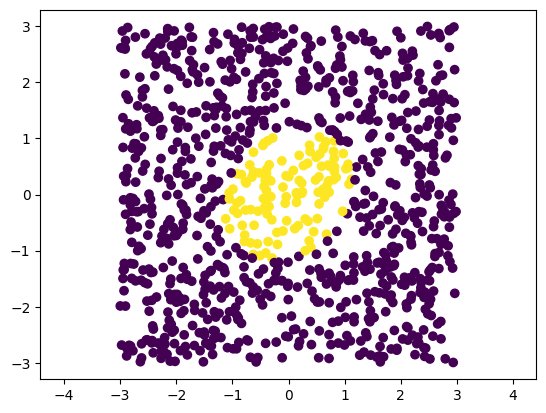

In [29]:
r = (np.random.rand(1000, 2) * 2 - 1) * 3

from fsd_path_planning.utils.math_utils import points_inside_ellipse

# f = njit(points_inside_ellipse)

center = np.array([0,0])
direction = np.array([1,1])
major_radius = 1.3
minor_radius = 1

# %timeit m = f(r, center, direction, major_radius, minor_radius)
# %timeit m = points_inside_ellipse(r, center, direction, major_radius, minor_radius)

m1 = f(r, center, direction, major_radius, minor_radius)
m2 = points_inside_ellipse(r, center, direction, major_radius, minor_radius)

np.testing.assert_array_equal(m1, m2)



plt.scatter(*r.T, c=m1)
plt.axis("equal")

In [ ]:
from fsd_path_planning.sorting_cones.trace_sorter.nearby_cone_search import create_angle_cache, create_seach_directions_cache, my_cdist_sq_euclidean

class NearbyConeSearcher:

    def __init__(self) -> None:
        self.caches_cache: dict[tuple[bytes, ConeTypes], tuple[dict, dict, np.ndarray, np.ndarray]] = {}

    def get_caches(self, cones: np.ndarray, cone_type: ConeTypes) -> tuple[dict, dict]:
        array_buffer = cones.tobytes()
        cache_key = (array_buffer, cone_type)
        if cache_key not in self.caches_cache:
            cones_xy = cones[:, :2]
            distance_matrix_square = my_cdist_sq_euclidean(cones_xy, cones_xy)
            np.fill_diagonal(distance_matrix_square, 1e7)
            cones_to_cones = cones_xy - cones_xy[:, None]

            self.caches_cache[cache_key] = create_seach_directions_cache(), create_angle_cache(), distance_matrix_square, cones_to_cones

        return self.caches_cache[cache_key]


    def number_of_cones_on_each_side_for_each_config(self, cones: np.ndarray, configs: np.ndarray, cone_type: ConeTypes, max_distance: float, max_angle: float) -> tuple[np.ndarray, np.ndarray]:
        cached_values = self.get_caches(cones, cone_type)
        return number_cones_on_each_side_for_each_config(cones, configs, cone_type, max_distance, max_angle, *cached_values[:])

In [ ]:
from fsd_path_planning.utils.utils import Timer

In [ ]:


def f1():
    ncs = NearbyConeSearcher()
    ncs.number_of_cones_on_each_side_for_each_config(cones_flat, configs, ConeTypes.LEFT,  6.0, np.pi / 2,)


ncs = NearbyConeSearcher()
ncs.number_of_cones_on_each_side_for_each_config(cones_flat, configs, ConeTypes.LEFT,  6.0, np.pi / 2,)
def f2():
    ncs.number_of_cones_on_each_side_for_each_config(cones_flat, configs, ConeTypes.LEFT,  6.0, np.pi / 2,) 


configs_changed = configs.copy()
configs_first = configs_changed[:,2]
configs_second = configs_changed[:,3]
configs_changed[:,2] = configs_second
configs_changed[:,3] = configs_first

def f3():
    ncs.number_of_cones_on_each_side_for_each_config(cones_flat, configs_changed, ConeTypes.LEFT,  6.0, np.pi / 2,)

%timeit f1()
%timeit f2()
%timeit f3()

2.04 ms ± 312 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
277 µs ± 46.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
280 µs ± 46.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
from fsd_path_planning.utils.utils import Timer

ncs = NearbyConeSearcher()
# ncs.number_of_cones_on_each_side_for_each_config(cones_flat, configs, ConeTypes.LEFT,  6.0, np.pi / 2,)
# ncs.number_of_cones_on_each_side_for_each_config(cones_flat, configs, ConeTypes.LEFT,  6.0, np.pi / 2,)

with Timer("first run"):
    ncs.number_of_cones_on_each_side_for_each_config(cones_flat, configs, ConeTypes.LEFT,  6.0, np.pi / 2,)

with Timer("second run"):
    ncs.number_of_cones_on_each_side_for_each_config(cones_flat, configs, ConeTypes.LEFT,  6.0, np.pi / 2,)

with Timer("third run"):
    ncs.number_of_cones_on_each_side_for_each_config(cones_flat, configs, ConeTypes.LEFT,  6.0, np.pi / 2,)


with Timer("fourth run"):
    ncs.number_of_cones_on_each_side_for_each_config(cones_flat, configs_changed, ConeTypes.LEFT,  6.0, np.pi / 2,)



a = ncs.number_of_cones_on_each_side_for_each_config(cones_flat, configs, ConeTypes.LEFT,  6.0, np.pi / 2,)
b = number_cones_on_each_side_for_each_config(cones_flat, configs, ConeTypes.LEFT,  6.0, np.pi / 2,)



np.testing.assert_array_equal(a, b)

Block 'first run' took 3195.299 μs
Block 'second run' took 3627.399 μs
Block 'third run' took 1836.700 μs
Block 'fourth run' took 603.099 μs


In [ ]:
# %lprun -f number_cones_on_each_side_for_each_config number_cones_on_each_side_for_each_config(cones_flat, configs, ConeTypes.LEFT,  6.0, np.pi / 2,)

In [ ]:
# %lprun -f number_cones_on_each_side_for_each_config_alt number_cones_on_each_side_for_each_config_alt(cones_flat, configs, ConeTypes.LEFT,  6.0, np.pi / 2,)

In [ ]:
from pathlib import Path

n_configs_list = []
n_cones_list = []
time_list = []

for line in Path('ncoesfec.txt').read_text().splitlines():
    n_configs, n_cones, time = eval(line)
    n_configs_list.append(n_configs)
    n_cones_list.append(n_cones)
    time_list.append(time)

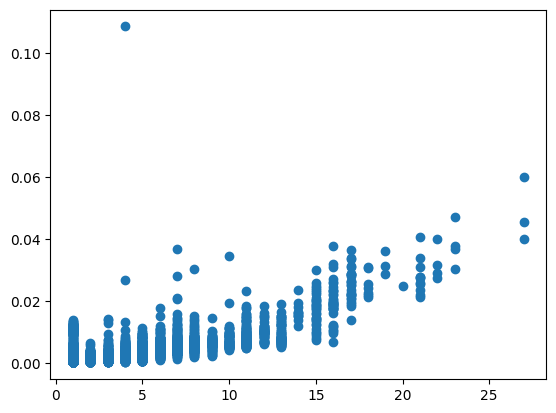

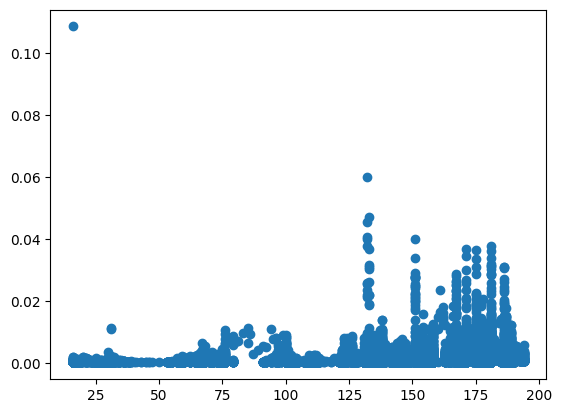

In [ ]:
plt.plot(n_configs_list, time_list, 'o')
plt.show()
plt.plot(n_cones_list, time_list, 'o')
# plt.ylim(0, 0.04)

In [ ]:
from numpy import array, int32

cones, configs, cone_type, dist, angle = (array([[ 1.24879456,  8.75      ],
       [ 2.18629456, 18.1875    ],
       [ 1.24879456, 12.375     ],
       [ 3.12379456, 19.6875    ],
       [ 1.43629456, 16.3125    ],
       [ 5.56129456, 20.8125    ],
       [14.74879456, 24.9375    ],
       [18.68629456, 25.6875    ],
       [21.31129456, 25.6875    ],
       [11.74879456, 23.625     ],
       [23.81129456, 25.875     ],
       [26.62379456, 26.0625    ],
       [27.89708838, 22.13631838],
       [30.18629456, 26.25      ],
       [31.12379456, 22.3125    ],
       [33.37379456, 27.        ],
       [33.56129456, 22.6875    ],
       [36.74879456, 23.0625    ],
       [36.93629456, 28.3125    ],
       [39.56129456, 29.4375    ],
       [39.93629456, 23.4375    ],
       [41.06129456, 31.125     ],
       [42.37379456, 24.1875    ],
       [42.74879456, 31.875     ],
       [44.43629456, 24.9375    ],
       [44.62379456, 31.3125    ],
       [45.18629456, 26.25      ],
       [45.56129456, 29.8125    ],
       [45.74879456, 28.125     ],
       [-1.93870544,  8.5625    ],
       [-1.75120544,  2.9375    ],
       [-2.12620544, 12.5625    ],
       [-1.93870544, 17.0625    ],
       [-1.18870544, 20.0625    ],
       [ 0.87379456, 22.3125    ],
       [ 2.56129456, 23.0625    ],
       [ 3.68629456, 23.8125    ],
       [ 7.24879456, 25.5       ],
       [10.43629456, 26.8125    ],
       [13.81129456, 28.3125    ],
       [17.93629456, 28.875     ],
       [21.12379456, 29.25      ],
       [23.81129456, 29.25      ],
       [26.43629456, 29.25      ],
       [29.62379456, 29.625     ],
       [32.43629456, 30.        ],
       [35.24879456, 30.9375    ],
       [37.49879456, 32.25      ],
       [39.74879456, 33.75      ],
       [40.87379456, 20.25      ],
       [41.81129456, 34.875     ],
       [43.87379456, 21.        ],
       [44.43629456, 34.875     ],
       [46.49879456, 22.6875    ],
       [46.68629456, 33.9375    ],
       [48.18629456, 32.625     ],
       [48.56129456, 24.9375    ],
       [48.93629456, 30.75      ],
       [49.31129456, 28.125     ],
       [-1.87620544,  4.5       ],
       [ 1.24879456,  4.625     ],
       [ 1.18629456,  6.0625    ],
       [-1.93870544,  5.8125    ]]), array([[43, 44, 46, 48, 52, 55, 58, 56, 53, 51, 49],
       [43, 44, 46, 48, 52, 55, 58, 56, 53, 49, -1],
       [43, 44, 46, 48, 52, 55, 58, 56, 51, 49, -1],
       [43, 44, 46, 48, 52, 55, 58, 53, 51, 49, -1],
       [43, 44, 46, 48, 52, 55, 58, 53, 49, -1, -1],
       [43, 44, 46, 48, 52, 55, 57, 58, 56, 53, 51],
       [43, 44, 46, 48, 52, 55, 57, 58, 56, 53, 49],
       [43, 44, 46, 48, 52, 55, 57, 58, 56, 51, 49],
       [43, 44, 46, 48, 52, 55, 57, 58, 53, 51, 49],
       [43, 44, 46, 48, 52, 55, 57, 58, 53, 49, -1],
       [43, 44, 46, 48, 52, 55, 57, 56, 53, 51, 49],
       [43, 44, 46, 48, 52, 55, 57, 56, 53, 49, -1],
       [43, 44, 46, 48, 52, 55, 57, 56, 51, 49, -1],
       [43, 44, 46, 48, 52, 54, 57, 58, 56, 53, 51],
       [43, 44, 46, 48, 52, 54, 57, 58, 56, 53, 49],
       [43, 44, 46, 48, 52, 54, 57, 58, 56, 51, 49],
       [43, 44, 46, 48, 52, 54, 57, 58, 53, 51, 49],
       [43, 44, 46, 48, 52, 54, 57, 58, 53, 49, -1],
       [43, 44, 46, 48, 52, 54, 57, 56, 53, 51, 49],
       [43, 44, 46, 48, 52, 54, 57, 56, 53, 49, -1],
       [43, 44, 46, 48, 52, 54, 57, 56, 51, 49, -1],
       [43, 44, 46, 48, 52, 54, 55, 58, 56, 53, 51],
       [43, 44, 46, 48, 52, 54, 55, 58, 56, 53, 49],
       [43, 44, 46, 48, 52, 54, 55, 58, 56, 51, 49],
       [43, 44, 46, 48, 52, 54, 55, 58, 53, 51, 49],
       [43, 44, 46, 48, 52, 54, 55, 58, 53, 49, -1],
       [43, 44, 46, 48, 52, 54, 55, 57, 58, 56, 53],
       [43, 44, 46, 48, 52, 54, 55, 57, 58, 56, 51],
       [43, 44, 46, 48, 52, 54, 55, 57, 58, 53, 51],
       [43, 44, 46, 48, 52, 54, 55, 57, 58, 53, 49],
       [43, 44, 46, 48, 52, 54, 55, 57, 56, 53, 51],
       [43, 44, 46, 48, 52, 54, 55, 57, 56, 53, 49],
       [43, 44, 46, 48, 52, 54, 55, 57, 56, 51, 49],
       [43, 44, 46, 48, 50, 54, 57, 58, 56, 53, 51],
       [43, 44, 46, 48, 50, 54, 57, 58, 56, 53, 49],
       [43, 44, 46, 48, 50, 54, 57, 58, 56, 51, 49],
       [43, 44, 46, 48, 50, 54, 57, 58, 53, 51, 49],
       [43, 44, 46, 48, 50, 54, 57, 58, 53, 49, -1],
       [43, 44, 46, 48, 50, 54, 57, 56, 53, 51, 49],
       [43, 44, 46, 48, 50, 54, 57, 56, 53, 49, -1],
       [43, 44, 46, 48, 50, 54, 57, 56, 51, 49, -1],
       [43, 44, 46, 48, 50, 54, 55, 58, 56, 53, 51],
       [43, 44, 46, 48, 50, 54, 55, 58, 56, 53, 49],
       [43, 44, 46, 48, 50, 54, 55, 58, 56, 51, 49],
       [43, 44, 46, 48, 50, 54, 55, 58, 53, 51, 49],
       [43, 44, 46, 48, 50, 54, 55, 58, 53, 49, -1],
       [43, 44, 46, 48, 50, 54, 55, 57, 58, 56, 53],
       [43, 44, 46, 48, 50, 54, 55, 57, 58, 56, 51],
       [43, 44, 46, 48, 50, 54, 55, 57, 58, 53, 51],
       [43, 44, 46, 48, 50, 54, 55, 57, 58, 53, 49],
       [43, 44, 46, 48, 50, 54, 55, 57, 56, 53, 51],
       [43, 44, 46, 48, 50, 54, 55, 57, 56, 53, 49],
       [43, 44, 46, 48, 50, 54, 55, 57, 56, 51, 49],
       [43, 44, 46, 48, 50, 52, 55, 58, 56, 53, 51],
       [43, 44, 46, 48, 50, 52, 55, 58, 56, 53, 49],
       [43, 44, 46, 48, 50, 52, 55, 58, 56, 51, 49],
       [43, 44, 46, 48, 50, 52, 55, 58, 53, 51, 49],
       [43, 44, 46, 48, 50, 52, 55, 58, 53, 49, -1],
       [43, 44, 46, 48, 50, 52, 55, 57, 58, 56, 53],
       [43, 44, 46, 48, 50, 52, 55, 57, 58, 56, 51],
       [43, 44, 46, 48, 50, 52, 55, 57, 58, 53, 51],
       [43, 44, 46, 48, 50, 52, 55, 57, 58, 53, 49],
       [43, 44, 46, 48, 50, 52, 55, 57, 56, 53, 51],
       [43, 44, 46, 48, 50, 52, 55, 57, 56, 53, 49],
       [43, 44, 46, 48, 50, 52, 55, 57, 56, 51, 49],
       [43, 44, 46, 48, 50, 52, 54, 57, 58, 56, 53],
       [43, 44, 46, 48, 50, 52, 54, 57, 58, 56, 51],
       [43, 44, 46, 48, 50, 52, 54, 57, 58, 53, 51],
       [43, 44, 46, 48, 50, 52, 54, 57, 58, 53, 49],
       [43, 44, 46, 48, 50, 52, 54, 57, 56, 53, 51],
       [43, 44, 46, 48, 50, 52, 54, 57, 56, 53, 49],
       [43, 44, 46, 48, 50, 52, 54, 57, 56, 51, 49],
       [43, 44, 46, 48, 50, 52, 54, 55, 58, 56, 53],
       [43, 44, 46, 48, 50, 52, 54, 55, 58, 56, 51],
       [43, 44, 46, 48, 50, 52, 54, 55, 58, 53, 51],
       [43, 44, 46, 48, 50, 52, 54, 55, 58, 53, 49],
       [43, 44, 46, 48, 50, 52, 54, 55, 57, 58, 56],
       [43, 44, 46, 48, 50, 52, 54, 55, 57, 58, 53],
       [43, 44, 46, 48, 50, 52, 54, 55, 57, 56, 53],
       [43, 44, 46, 48, 50, 52, 54, 55, 57, 56, 51],
       [43, 44, 46, 47, 50, 54, 57, 58, 56, 53, 51],
       [43, 44, 46, 47, 50, 54, 57, 58, 56, 53, 49],
       [43, 44, 46, 47, 50, 54, 57, 58, 56, 51, 49],
       [43, 44, 46, 47, 50, 54, 57, 58, 53, 51, 49],
       [43, 44, 46, 47, 50, 54, 57, 58, 53, 49, -1],
       [43, 44, 46, 47, 50, 54, 57, 56, 53, 51, 49],
       [43, 44, 46, 47, 50, 54, 57, 56, 53, 49, -1],
       [43, 44, 46, 47, 50, 54, 57, 56, 51, 49, -1],
       [43, 44, 46, 47, 50, 54, 55, 58, 56, 53, 51],
       [43, 44, 46, 47, 50, 54, 55, 58, 56, 53, 49],
       [43, 44, 46, 47, 50, 54, 55, 58, 56, 51, 49],
       [43, 44, 46, 47, 50, 54, 55, 58, 53, 51, 49],
       [43, 44, 46, 47, 50, 54, 55, 58, 53, 49, -1],
       [43, 44, 46, 47, 50, 54, 55, 57, 58, 56, 53],
       [43, 44, 46, 47, 50, 54, 55, 57, 58, 56, 51],
       [43, 44, 46, 47, 50, 54, 55, 57, 58, 53, 51],
       [43, 44, 46, 47, 50, 54, 55, 57, 58, 53, 49],
       [43, 44, 46, 47, 50, 54, 55, 57, 56, 53, 51],
       [43, 44, 46, 47, 50, 54, 55, 57, 56, 53, 49],
       [43, 44, 46, 47, 50, 54, 55, 57, 56, 51, 49],
       [43, 44, 46, 47, 50, 52, 55, 58, 56, 53, 51],
       [43, 44, 46, 47, 50, 52, 55, 58, 56, 53, 49],
       [43, 44, 46, 47, 50, 52, 55, 58, 56, 51, 49],
       [43, 44, 46, 47, 50, 52, 55, 58, 53, 51, 49],
       [43, 44, 46, 47, 50, 52, 55, 58, 53, 49, -1],
       [43, 44, 46, 47, 50, 52, 55, 57, 58, 56, 53],
       [43, 44, 46, 47, 50, 52, 55, 57, 58, 56, 51],
       [43, 44, 46, 47, 50, 52, 55, 57, 58, 53, 51],
       [43, 44, 46, 47, 50, 52, 55, 57, 58, 53, 49],
       [43, 44, 46, 47, 50, 52, 55, 57, 56, 53, 51],
       [43, 44, 46, 47, 50, 52, 55, 57, 56, 53, 49],
       [43, 44, 46, 47, 50, 52, 55, 57, 56, 51, 49],
       [43, 44, 46, 47, 50, 52, 54, 57, 58, 56, 53],
       [43, 44, 46, 47, 50, 52, 54, 57, 58, 56, 51],
       [43, 44, 46, 47, 50, 52, 54, 57, 58, 53, 51],
       [43, 44, 46, 47, 50, 52, 54, 57, 58, 53, 49],
       [43, 44, 46, 47, 50, 52, 54, 57, 56, 53, 51],
       [43, 44, 46, 47, 50, 52, 54, 57, 56, 53, 49],
       [43, 44, 46, 47, 50, 52, 54, 57, 56, 51, 49],
       [43, 44, 46, 47, 50, 52, 54, 55, 58, 56, 53],
       [43, 44, 46, 47, 50, 52, 54, 55, 58, 56, 51],
       [43, 44, 46, 47, 50, 52, 54, 55, 58, 53, 51],
       [43, 44, 46, 47, 50, 52, 54, 55, 58, 53, 49],
       [43, 44, 46, 47, 50, 52, 54, 55, 57, 58, 56],
       [43, 44, 46, 47, 50, 52, 54, 55, 57, 58, 53],
       [43, 44, 46, 47, 50, 52, 54, 55, 57, 56, 53],
       [43, 44, 46, 47, 50, 52, 54, 55, 57, 56, 51],
       [43, 44, 46, 47, 48, 52, 55, 58, 56, 53, 51],
       [43, 44, 46, 47, 48, 52, 55, 58, 56, 53, 49],
       [43, 44, 46, 47, 48, 52, 55, 58, 56, 51, 49],
       [43, 44, 46, 47, 48, 52, 55, 58, 53, 51, 49],
       [43, 44, 46, 47, 48, 52, 55, 58, 53, 49, -1],
       [43, 44, 46, 47, 48, 52, 55, 57, 58, 56, 53],
       [43, 44, 46, 47, 48, 52, 55, 57, 58, 56, 51],
       [43, 44, 46, 47, 48, 52, 55, 57, 58, 53, 51],
       [43, 44, 46, 47, 48, 52, 55, 57, 58, 53, 49],
       [43, 44, 46, 47, 48, 52, 55, 57, 56, 53, 51],
       [43, 44, 46, 47, 48, 52, 55, 57, 56, 53, 49],
       [43, 44, 46, 47, 48, 52, 55, 57, 56, 51, 49],
       [43, 44, 46, 47, 48, 52, 54, 57, 58, 56, 53],
       [43, 44, 46, 47, 48, 52, 54, 57, 58, 56, 51],
       [43, 44, 46, 47, 48, 52, 54, 57, 58, 53, 51],
       [43, 44, 46, 47, 48, 52, 54, 57, 58, 53, 49],
       [43, 44, 46, 47, 48, 52, 54, 57, 56, 53, 51],
       [43, 44, 46, 47, 48, 52, 54, 57, 56, 53, 49],
       [43, 44, 46, 47, 48, 52, 54, 57, 56, 51, 49],
       [43, 44, 46, 47, 48, 52, 54, 55, 58, 56, 53],
       [43, 44, 46, 47, 48, 52, 54, 55, 58, 56, 51],
       [43, 44, 46, 47, 48, 52, 54, 55, 58, 53, 51],
       [43, 44, 46, 47, 48, 52, 54, 55, 58, 53, 49],
       [43, 44, 46, 47, 48, 52, 54, 55, 57, 58, 56],
       [43, 44, 46, 47, 48, 52, 54, 55, 57, 58, 53],
       [43, 44, 46, 47, 48, 52, 54, 55, 57, 56, 53],
       [43, 44, 46, 47, 48, 52, 54, 55, 57, 56, 51],
       [43, 44, 46, 47, 48, 50, 54, 57, 58, 56, 53],
       [43, 44, 46, 47, 48, 50, 54, 57, 58, 56, 51],
       [43, 44, 46, 47, 48, 50, 54, 57, 58, 53, 51],
       [43, 44, 46, 47, 48, 50, 54, 57, 58, 53, 49],
       [43, 44, 46, 47, 48, 50, 54, 57, 56, 53, 51],
       [43, 44, 46, 47, 48, 50, 54, 57, 56, 53, 49],
       [43, 44, 46, 47, 48, 50, 54, 57, 56, 51, 49],
       [43, 44, 46, 47, 48, 50, 54, 55, 58, 56, 53],
       [43, 44, 46, 47, 48, 50, 54, 55, 58, 56, 51],
       [43, 44, 46, 47, 48, 50, 54, 55, 58, 53, 51],
       [43, 44, 46, 47, 48, 50, 54, 55, 58, 53, 49],
       [43, 44, 46, 47, 48, 50, 54, 55, 57, 58, 56],
       [43, 44, 46, 47, 48, 50, 54, 55, 57, 58, 53],
       [43, 44, 46, 47, 48, 50, 54, 55, 57, 56, 53],
       [43, 44, 46, 47, 48, 50, 54, 55, 57, 56, 51],
       [43, 44, 46, 47, 48, 50, 52, 55, 58, 56, 53],
       [43, 44, 46, 47, 48, 50, 52, 55, 58, 56, 51],
       [43, 44, 46, 47, 48, 50, 52, 55, 58, 53, 51],
       [43, 44, 46, 47, 48, 50, 52, 55, 58, 53, 49],
       [43, 44, 46, 47, 48, 50, 52, 55, 57, 58, 56],
       [43, 44, 46, 47, 48, 50, 52, 55, 57, 58, 53],
       [43, 44, 46, 47, 48, 50, 52, 55, 57, 56, 53],
       [43, 44, 46, 47, 48, 50, 52, 55, 57, 56, 51],
       [43, 44, 46, 47, 48, 50, 52, 54, 57, 58, 56],
       [43, 44, 46, 47, 48, 50, 52, 54, 57, 58, 53],
       [43, 44, 46, 47, 48, 50, 52, 54, 57, 56, 53],
       [43, 44, 46, 47, 48, 50, 52, 54, 57, 56, 51],
       [43, 44, 46, 47, 48, 50, 52, 54, 55, 58, 56],
       [43, 44, 46, 47, 48, 50, 52, 54, 55, 58, 53],
       [43, 44, 46, 47, 48, 50, 52, 54, 55, 57, 58],
       [43, 44, 46, 47, 48, 50, 52, 54, 55, 57, 56],
       [43, 44, 45, 47, 50, 54, 57, 58, 56, 53, 51],
       [43, 44, 45, 47, 50, 54, 57, 58, 56, 53, 49],
       [43, 44, 45, 47, 50, 54, 57, 58, 56, 51, 49],
       [43, 44, 45, 47, 50, 54, 57, 58, 53, 51, 49],
       [43, 44, 45, 47, 50, 54, 57, 58, 53, 49, -1],
       [43, 44, 45, 47, 50, 54, 57, 56, 53, 51, 49],
       [43, 44, 45, 47, 50, 54, 57, 56, 53, 49, -1],
       [43, 44, 45, 47, 50, 54, 57, 56, 51, 49, -1],
       [43, 44, 45, 47, 50, 54, 55, 58, 56, 53, 51],
       [43, 44, 45, 47, 50, 54, 55, 58, 56, 53, 49],
       [43, 44, 45, 47, 50, 54, 55, 58, 56, 51, 49],
       [43, 44, 45, 47, 50, 54, 55, 58, 53, 51, 49],
       [43, 44, 45, 47, 50, 54, 55, 58, 53, 49, -1],
       [43, 44, 45, 47, 50, 54, 55, 57, 58, 56, 53],
       [43, 44, 45, 47, 50, 54, 55, 57, 58, 56, 51],
       [43, 44, 45, 47, 50, 54, 55, 57, 58, 53, 51],
       [43, 44, 45, 47, 50, 54, 55, 57, 58, 53, 49],
       [43, 44, 45, 47, 50, 54, 55, 57, 56, 53, 51],
       [43, 44, 45, 47, 50, 54, 55, 57, 56, 53, 49],
       [43, 44, 45, 47, 50, 54, 55, 57, 56, 51, 49],
       [43, 44, 45, 47, 50, 52, 55, 58, 56, 53, 51],
       [43, 44, 45, 47, 50, 52, 55, 58, 56, 53, 49],
       [43, 44, 45, 47, 50, 52, 55, 58, 56, 51, 49],
       [43, 44, 45, 47, 50, 52, 55, 58, 53, 51, 49],
       [43, 44, 45, 47, 50, 52, 55, 58, 53, 49, -1],
       [43, 44, 45, 47, 50, 52, 55, 57, 58, 56, 53],
       [43, 44, 45, 47, 50, 52, 55, 57, 58, 56, 51],
       [43, 44, 45, 47, 50, 52, 55, 57, 58, 53, 51],
       [43, 44, 45, 47, 50, 52, 55, 57, 58, 53, 49],
       [43, 44, 45, 47, 50, 52, 55, 57, 56, 53, 51],
       [43, 44, 45, 47, 50, 52, 55, 57, 56, 53, 49],
       [43, 44, 45, 47, 50, 52, 55, 57, 56, 51, 49],
       [43, 44, 45, 47, 50, 52, 54, 57, 58, 56, 53],
       [43, 44, 45, 47, 50, 52, 54, 57, 58, 56, 51],
       [43, 44, 45, 47, 50, 52, 54, 57, 58, 53, 51],
       [43, 44, 45, 47, 50, 52, 54, 57, 58, 53, 49],
       [43, 44, 45, 47, 50, 52, 54, 57, 56, 53, 51],
       [43, 44, 45, 47, 50, 52, 54, 57, 56, 53, 49],
       [43, 44, 45, 47, 50, 52, 54, 57, 56, 51, 49],
       [43, 44, 45, 47, 50, 52, 54, 55, 58, 56, 53],
       [43, 44, 45, 47, 50, 52, 54, 55, 58, 56, 51],
       [43, 44, 45, 47, 50, 52, 54, 55, 58, 53, 51],
       [43, 44, 45, 47, 50, 52, 54, 55, 58, 53, 49],
       [43, 44, 45, 47, 50, 52, 54, 55, 57, 58, 56],
       [43, 44, 45, 47, 50, 52, 54, 55, 57, 58, 53],
       [43, 44, 45, 47, 50, 52, 54, 55, 57, 56, 53],
       [43, 44, 45, 47, 50, 52, 54, 55, 57, 56, 51],
       [43, 44, 45, 47, 48, 52, 55, 58, 56, 53, 51],
       [43, 44, 45, 47, 48, 52, 55, 58, 56, 53, 49],
       [43, 44, 45, 47, 48, 52, 55, 58, 56, 51, 49],
       [43, 44, 45, 47, 48, 52, 55, 58, 53, 51, 49],
       [43, 44, 45, 47, 48, 52, 55, 58, 53, 49, -1],
       [43, 44, 45, 47, 48, 52, 55, 57, 58, 56, 53],
       [43, 44, 45, 47, 48, 52, 55, 57, 58, 56, 51],
       [43, 44, 45, 47, 48, 52, 55, 57, 58, 53, 51],
       [43, 44, 45, 47, 48, 52, 55, 57, 58, 53, 49],
       [43, 44, 45, 47, 48, 52, 55, 57, 56, 53, 51],
       [43, 44, 45, 47, 48, 52, 55, 57, 56, 53, 49],
       [43, 44, 45, 47, 48, 52, 55, 57, 56, 51, 49],
       [43, 44, 45, 47, 48, 52, 54, 57, 58, 56, 53],
       [43, 44, 45, 47, 48, 52, 54, 57, 58, 56, 51],
       [43, 44, 45, 47, 48, 52, 54, 57, 58, 53, 51],
       [43, 44, 45, 47, 48, 52, 54, 57, 58, 53, 49],
       [43, 44, 45, 47, 48, 52, 54, 57, 56, 53, 51],
       [43, 44, 45, 47, 48, 52, 54, 57, 56, 53, 49],
       [43, 44, 45, 47, 48, 52, 54, 57, 56, 51, 49],
       [43, 44, 45, 47, 48, 52, 54, 55, 58, 56, 53],
       [43, 44, 45, 47, 48, 52, 54, 55, 58, 56, 51],
       [43, 44, 45, 47, 48, 52, 54, 55, 58, 53, 51],
       [43, 44, 45, 47, 48, 52, 54, 55, 58, 53, 49],
       [43, 44, 45, 47, 48, 52, 54, 55, 57, 58, 56],
       [43, 44, 45, 47, 48, 52, 54, 55, 57, 58, 53],
       [43, 44, 45, 47, 48, 52, 54, 55, 57, 56, 53],
       [43, 44, 45, 47, 48, 52, 54, 55, 57, 56, 51],
       [43, 44, 45, 47, 48, 50, 54, 57, 58, 56, 53],
       [43, 44, 45, 47, 48, 50, 54, 57, 58, 56, 51],
       [43, 44, 45, 47, 48, 50, 54, 57, 58, 53, 51],
       [43, 44, 45, 47, 48, 50, 54, 57, 58, 53, 49],
       [43, 44, 45, 47, 48, 50, 54, 57, 56, 53, 51],
       [43, 44, 45, 47, 48, 50, 54, 57, 56, 53, 49],
       [43, 44, 45, 47, 48, 50, 54, 57, 56, 51, 49],
       [43, 44, 45, 47, 48, 50, 54, 55, 58, 56, 53],
       [43, 44, 45, 47, 48, 50, 54, 55, 58, 56, 51],
       [43, 44, 45, 47, 48, 50, 54, 55, 58, 53, 51],
       [43, 44, 45, 47, 48, 50, 54, 55, 58, 53, 49],
       [43, 44, 45, 47, 48, 50, 54, 55, 57, 58, 56],
       [43, 44, 45, 47, 48, 50, 54, 55, 57, 58, 53],
       [43, 44, 45, 47, 48, 50, 54, 55, 57, 56, 53],
       [43, 44, 45, 47, 48, 50, 54, 55, 57, 56, 51],
       [43, 44, 45, 47, 48, 50, 52, 55, 58, 56, 53],
       [43, 44, 45, 47, 48, 50, 52, 55, 58, 56, 51],
       [43, 44, 45, 47, 48, 50, 52, 55, 58, 53, 51],
       [43, 44, 45, 47, 48, 50, 52, 55, 58, 53, 49],
       [43, 44, 45, 47, 48, 50, 52, 55, 57, 58, 56],
       [43, 44, 45, 47, 48, 50, 52, 55, 57, 58, 53],
       [43, 44, 45, 47, 48, 50, 52, 55, 57, 56, 53],
       [43, 44, 45, 47, 48, 50, 52, 55, 57, 56, 51],
       [43, 44, 45, 47, 48, 50, 52, 54, 57, 58, 56],
       [43, 44, 45, 47, 48, 50, 52, 54, 57, 58, 53],
       [43, 44, 45, 47, 48, 50, 52, 54, 57, 56, 53],
       [43, 44, 45, 47, 48, 50, 52, 54, 57, 56, 51],
       [43, 44, 45, 47, 48, 50, 52, 54, 55, 58, 56],
       [43, 44, 45, 47, 48, 50, 52, 54, 55, 58, 53],
       [43, 44, 45, 47, 48, 50, 52, 54, 55, 57, 58],
       [43, 44, 45, 47, 48, 50, 52, 54, 55, 57, 56],
       [43, 44, 45, 46, 48, 52, 55, 58, 56, 53, 51],
       [43, 44, 45, 46, 48, 52, 55, 58, 56, 53, 49],
       [43, 44, 45, 46, 48, 52, 55, 58, 56, 51, 49],
       [43, 44, 45, 46, 48, 52, 55, 58, 53, 51, 49],
       [43, 44, 45, 46, 48, 52, 55, 58, 53, 49, -1],
       [43, 44, 45, 46, 48, 52, 55, 57, 58, 56, 53],
       [43, 44, 45, 46, 48, 52, 55, 57, 58, 56, 51],
       [43, 44, 45, 46, 48, 52, 55, 57, 58, 53, 51],
       [43, 44, 45, 46, 48, 52, 55, 57, 58, 53, 49],
       [43, 44, 45, 46, 48, 52, 55, 57, 56, 53, 51],
       [43, 44, 45, 46, 48, 52, 55, 57, 56, 53, 49],
       [43, 44, 45, 46, 48, 52, 55, 57, 56, 51, 49],
       [43, 44, 45, 46, 48, 52, 54, 57, 58, 56, 53],
       [43, 44, 45, 46, 48, 52, 54, 57, 58, 56, 51],
       [43, 44, 45, 46, 48, 52, 54, 57, 58, 53, 51],
       [43, 44, 45, 46, 48, 52, 54, 57, 58, 53, 49],
       [43, 44, 45, 46, 48, 52, 54, 57, 56, 53, 51],
       [43, 44, 45, 46, 48, 52, 54, 57, 56, 53, 49],
       [43, 44, 45, 46, 48, 52, 54, 57, 56, 51, 49],
       [43, 44, 45, 46, 48, 52, 54, 55, 58, 56, 53],
       [43, 44, 45, 46, 48, 52, 54, 55, 58, 56, 51],
       [43, 44, 45, 46, 48, 52, 54, 55, 58, 53, 51],
       [43, 44, 45, 46, 48, 52, 54, 55, 58, 53, 49],
       [43, 44, 45, 46, 48, 52, 54, 55, 57, 58, 56],
       [43, 44, 45, 46, 48, 52, 54, 55, 57, 58, 53],
       [43, 44, 45, 46, 48, 52, 54, 55, 57, 56, 53],
       [43, 44, 45, 46, 48, 52, 54, 55, 57, 56, 51],
       [43, 44, 45, 46, 48, 50, 54, 57, 58, 56, 53],
       [43, 44, 45, 46, 48, 50, 54, 57, 58, 56, 51],
       [43, 44, 45, 46, 48, 50, 54, 57, 58, 53, 51],
       [43, 44, 45, 46, 48, 50, 54, 57, 58, 53, 49],
       [43, 44, 45, 46, 48, 50, 54, 57, 56, 53, 51],
       [43, 44, 45, 46, 48, 50, 54, 57, 56, 53, 49],
       [43, 44, 45, 46, 48, 50, 54, 57, 56, 51, 49],
       [43, 44, 45, 46, 48, 50, 54, 55, 58, 56, 53],
       [43, 44, 45, 46, 48, 50, 54, 55, 58, 56, 51],
       [43, 44, 45, 46, 48, 50, 54, 55, 58, 53, 51],
       [43, 44, 45, 46, 48, 50, 54, 55, 58, 53, 49],
       [43, 44, 45, 46, 48, 50, 54, 55, 57, 58, 56],
       [43, 44, 45, 46, 48, 50, 54, 55, 57, 58, 53],
       [43, 44, 45, 46, 48, 50, 54, 55, 57, 56, 53],
       [43, 44, 45, 46, 48, 50, 54, 55, 57, 56, 51],
       [43, 44, 45, 46, 48, 50, 52, 55, 58, 56, 53],
       [43, 44, 45, 46, 48, 50, 52, 55, 58, 56, 51],
       [43, 44, 45, 46, 48, 50, 52, 55, 58, 53, 51],
       [43, 44, 45, 46, 48, 50, 52, 55, 58, 53, 49],
       [43, 44, 45, 46, 48, 50, 52, 55, 57, 58, 56],
       [43, 44, 45, 46, 48, 50, 52, 55, 57, 58, 53],
       [43, 44, 45, 46, 48, 50, 52, 55, 57, 56, 53],
       [43, 44, 45, 46, 48, 50, 52, 55, 57, 56, 51],
       [43, 44, 45, 46, 48, 50, 52, 54, 57, 58, 56],
       [43, 44, 45, 46, 48, 50, 52, 54, 57, 58, 53],
       [43, 44, 45, 46, 48, 50, 52, 54, 57, 56, 53],
       [43, 44, 45, 46, 48, 50, 52, 54, 57, 56, 51],
       [43, 44, 45, 46, 48, 50, 52, 54, 55, 58, 56],
       [43, 44, 45, 46, 48, 50, 52, 54, 55, 58, 53],
       [43, 44, 45, 46, 48, 50, 52, 54, 55, 57, 58],
       [43, 44, 45, 46, 48, 50, 52, 54, 55, 57, 56],
       [43, 44, 45, 46, 47, 50, 54, 57, 58, 56, 53],
       [43, 44, 45, 46, 47, 50, 54, 57, 58, 56, 51],
       [43, 44, 45, 46, 47, 50, 54, 57, 58, 53, 51],
       [43, 44, 45, 46, 47, 50, 54, 57, 58, 53, 49],
       [43, 44, 45, 46, 47, 50, 54, 57, 56, 53, 51],
       [43, 44, 45, 46, 47, 50, 54, 57, 56, 53, 49],
       [43, 44, 45, 46, 47, 50, 54, 57, 56, 51, 49],
       [43, 44, 45, 46, 47, 50, 54, 55, 58, 56, 53],
       [43, 44, 45, 46, 47, 50, 54, 55, 58, 56, 51],
       [43, 44, 45, 46, 47, 50, 54, 55, 58, 53, 51],
       [43, 44, 45, 46, 47, 50, 54, 55, 58, 53, 49],
       [43, 44, 45, 46, 47, 50, 54, 55, 57, 58, 56],
       [43, 44, 45, 46, 47, 50, 54, 55, 57, 58, 53],
       [43, 44, 45, 46, 47, 50, 54, 55, 57, 56, 53],
       [43, 44, 45, 46, 47, 50, 54, 55, 57, 56, 51],
       [43, 44, 45, 46, 47, 50, 52, 55, 58, 56, 53],
       [43, 44, 45, 46, 47, 50, 52, 55, 58, 56, 51],
       [43, 44, 45, 46, 47, 50, 52, 55, 58, 53, 51],
       [43, 44, 45, 46, 47, 50, 52, 55, 58, 53, 49],
       [43, 44, 45, 46, 47, 50, 52, 55, 57, 58, 56],
       [43, 44, 45, 46, 47, 50, 52, 55, 57, 58, 53],
       [43, 44, 45, 46, 47, 50, 52, 55, 57, 56, 53],
       [43, 44, 45, 46, 47, 50, 52, 55, 57, 56, 51],
       [43, 44, 45, 46, 47, 50, 52, 54, 57, 58, 56],
       [43, 44, 45, 46, 47, 50, 52, 54, 57, 58, 53],
       [43, 44, 45, 46, 47, 50, 52, 54, 57, 56, 53],
       [43, 44, 45, 46, 47, 50, 52, 54, 57, 56, 51],
       [43, 44, 45, 46, 47, 50, 52, 54, 55, 58, 56],
       [43, 44, 45, 46, 47, 50, 52, 54, 55, 58, 53],
       [43, 44, 45, 46, 47, 50, 52, 54, 55, 57, 58],
       [43, 44, 45, 46, 47, 50, 52, 54, 55, 57, 56],
       [43, 44, 45, 46, 47, 48, 52, 55, 58, 56, 53],
       [43, 44, 45, 46, 47, 48, 52, 55, 58, 56, 51],
       [43, 44, 45, 46, 47, 48, 52, 55, 58, 53, 51],
       [43, 44, 45, 46, 47, 48, 52, 55, 58, 53, 49],
       [43, 44, 45, 46, 47, 48, 52, 55, 57, 58, 56],
       [43, 44, 45, 46, 47, 48, 52, 55, 57, 58, 53],
       [43, 44, 45, 46, 47, 48, 52, 55, 57, 56, 53],
       [43, 44, 45, 46, 47, 48, 52, 55, 57, 56, 51],
       [43, 44, 45, 46, 47, 48, 52, 54, 57, 58, 56],
       [43, 44, 45, 46, 47, 48, 52, 54, 57, 58, 53],
       [43, 44, 45, 46, 47, 48, 52, 54, 57, 56, 53],
       [43, 44, 45, 46, 47, 48, 52, 54, 57, 56, 51],
       [43, 44, 45, 46, 47, 48, 52, 54, 55, 58, 56],
       [43, 44, 45, 46, 47, 48, 52, 54, 55, 58, 53],
       [43, 44, 45, 46, 47, 48, 52, 54, 55, 57, 58],
       [43, 44, 45, 46, 47, 48, 52, 54, 55, 57, 56],
       [43, 44, 45, 46, 47, 48, 50, 54, 57, 58, 56],
       [43, 44, 45, 46, 47, 48, 50, 54, 57, 58, 53],
       [43, 44, 45, 46, 47, 48, 50, 54, 57, 56, 53],
       [43, 44, 45, 46, 47, 48, 50, 54, 57, 56, 51],
       [43, 44, 45, 46, 47, 48, 50, 54, 55, 58, 56],
       [43, 44, 45, 46, 47, 48, 50, 54, 55, 58, 53],
       [43, 44, 45, 46, 47, 48, 50, 54, 55, 57, 58],
       [43, 44, 45, 46, 47, 48, 50, 54, 55, 57, 56],
       [43, 44, 45, 46, 47, 48, 50, 52, 55, 58, 56],
       [43, 44, 45, 46, 47, 48, 50, 52, 55, 58, 53],
       [43, 44, 45, 46, 47, 48, 50, 52, 55, 57, 58],
       [43, 44, 45, 46, 47, 48, 50, 52, 55, 57, 56],
       [43, 44, 45, 46, 47, 48, 50, 52, 54, 57, 58],
       [43, 44, 45, 46, 47, 48, 50, 52, 54, 57, 56],
       [43, 44, 45, 46, 47, 48, 50, 52, 54, 55, 58],
       [43, 44, 45, 46, 47, 48, 50, 52, 54, 55, 57]], dtype=int32), ConeTypes.BLUE, 6.0, 1.5707963267948966)


# for i,c in enumerate(configs):
#     c = c[c != -1]
#     plt.plot(*cones.T, 'o')
#     plt.plot(*cones[c].T, 'o-')
#     plt.title(f'Config {i}')
#     plt.show()

In [ ]:
from numba import njit
import numba as nb
from fsd_path_planning.cone_matching.functional_cone_matching import calculate_search_direction_for_one
from sys import maxsize

@njit
def create_cache_dict():
    return {(maxsize,maxsize,maxsize): np.array([-1.0, -1.0])}



@njit
def calculate_match_search_direction_for_one_if_not_in_cache(cones_xy, key, cone_type, d):
    if key not in d:
        d[key] = calculate_search_direction_for_one(cones_xy, key[0::2], cone_type)

    

    return d[key]

@njit
def pre_caluclate_search_directions(cones, configs, cone_type):
    cones_xy = cones[:, :2]
    d = create_cache_dict()
    for c in configs:
        c = c[c != -1]
        assert len(c) >= 2

        key_first = (c[0], maxsize, c[1])
        key_last = (c[-2], maxsize, c[-1])
        
        calculate_match_search_direction_for_one_if_not_in_cache(cones_xy, key_first, cone_type, d)
        calculate_match_search_direction_for_one_if_not_in_cache(cones_xy, key_last, cone_type, d)

        for j in range(1, len(c)-1):
            key = (c[j-1], c[j], c[j+1])
            calculate_match_search_direction_for_one_if_not_in_cache(cones_xy, key, cone_type, d)

            
    return d




In [ ]:
from fsd_path_planning.sorting_cones.trace_sorter.nearby_cone_search import *
from fsd_path_planning.utils.math_utils import vec_angle_between, angle_from_2d_vector, angle_difference, norm_of_last_axis
from fsd_path_planning.utils.utils import Timer

@njit
def create_angle_cache():
    d = {
        ((maxsize, maxsize, maxsize), maxsize, maxsize, False): False,
    }
   
    return d

@njit
def calculate_angle_between_search_direction_of_cone_and_other_cone_too_large(all_cone_directions, directions_key, cone_idx, other_cone_idx, search_directions_cache, search_angle, negate_direction):
    from_cone_to_other_cone = all_cone_directions[cone_idx, other_cone_idx]

    search_direction = search_directions_cache[directions_key]
    if negate_direction:
        search_direction = -search_direction

    return vec_angle_between(from_cone_to_other_cone, search_direction) < search_angle / 2


@njit
def calculate_angle_between_search_direction_of_cone_and_other_cone_if_not_in_cache(all_cone_directions, directions_key, cone_idx, other_cone_idx, search_directions_cache, angle_cache, search_angle, negate_direction):
    global hits, misses
    key = (directions_key, cone_idx, other_cone_idx, negate_direction)
    if key not in angle_cache:    
        angle_cache[key] = calculate_angle_between_search_direction_of_cone_and_other_cone_too_large(all_cone_directions, directions_key, cone_idx, other_cone_idx, search_directions_cache, search_angle, negate_direction)
    
    return angle_cache[key]

    


@njit
def calculate_visible_cones_for_one_cone(
    cone_idx,
    distance_matrix_mask,
    search_direction_key,
    cone_to_cone_vecs,
    search_angle,
    negate_direction,
    search_direction_cache,
    angles_between_search_direction_and_other_cone_cache,
    idxs_to_check
):
    
    angle_mask = np.zeros(len(idxs_to_check), dtype=np.bool_)
    for i in range(len(idxs_to_check)):
        idx = idxs_to_check[i]

        if distance_matrix_mask[cone_idx, idx] == 0:
            continue
       
        value = calculate_angle_between_search_direction_of_cone_and_other_cone_if_not_in_cache(
            cone_to_cone_vecs,
            search_direction_key,
            cone_idx,
            idx,
            search_direction_cache,
            angles_between_search_direction_and_other_cone_cache,
            search_angle,
            negate_direction,
        )
        angle_mask[i] = value

    

    mask_distance = distance_matrix_mask[cone_idx]

    return angle_mask & mask_distance[idxs_to_check]
    

@njit
def new_number_cones_on_each_side_for_each_config(
    cones: FloatArray,
    configs: IntArray,
    cone_type: ConeTypes,
    search_distance: float,
    search_angle: float,
) -> tuple[IntArray, IntArray]:
    """
    For each configuration, find the number of cones that are on the expected side of
    the track, and the number of cones that are on the wrong side of the track.

    Args:
        cones: array of cone positions and types
        configs: array of sorted cone configurations
        cone_type: the type of cone we are considering
        search_distance: the distance to search for cones
        search_angle: the angle to search for cones

    Returns:
        A tuple of two arrays, the first is the number of cones on the correct side of
        the track, the second is the number of cones on the wrong side of the track.
    """
    cones_xy = cones[:, :2]

    idxs_in_all_configs = np.unique(configs)
    idxs_in_all_configs = idxs_in_all_configs[idxs_in_all_configs != -1]

    from_cone_to_cone = cones_xy - np.expand_dims(cones_xy, 1)
    distance_matrix = norm_of_last_axis(from_cone_to_cone)
    np.fill_diagonal(distance_matrix, np.inf)
    distance_matrix_mask = distance_matrix < search_distance

    search_directions_cache = pre_caluclate_search_directions(cones, configs, cone_type)

    close_idxs = find_nearby_cones_for_idxs(idxs_in_all_configs, distance_matrix ** 2, search_distance)

    n_bad_cones_for_all = np.zeros(len(configs), dtype=np.int_)
    n_good_cones_for_all = np.zeros(len(configs), dtype=np.int_)

    angle_cache = create_angle_cache()
    for i, c in enumerate(configs):
        c = c[c != -1]
        
        
        extra_idxs = sorted_set_diff(idxs_in_all_configs, c)
        other_idxs = np.concatenate((close_idxs, extra_idxs))
    
        
        for j in range(len(c)):
            
            if j == 0:
                key = (c[j], maxsize, c[j+1])
            elif j == len(c)-1:
                key = (c[j-1], maxsize, c[j])
            else:
                key = (c[j-1], c[j], c[j+1])
            
            
            
            mask_good = calculate_visible_cones_for_one_cone(c[j], distance_matrix_mask, key, from_cone_to_cone, search_angle, False, search_directions_cache, angle_cache, idxs_to_check=other_idxs)
            mask_bad = calculate_visible_cones_for_one_cone(c[j], distance_matrix_mask, key, from_cone_to_cone, search_angle, True, search_directions_cache, angle_cache, idxs_to_check=other_idxs)
            
            n_good_cones_for_all[i] += mask_good.sum()
            n_bad_cones_for_all[i] += mask_bad.sum()


    return n_good_cones_for_all, n_bad_cones_for_all


# cones = np.array([
#     [0,2,0],
#     [0,4,0],
#     [0,6,0],
#     [0,-2,0],
#     [0,-4,0],
#     [0,-6,0],
#     [0, -8, 0],
# ], dtype=float
# )
# configs = np.array(
#     [[0,1,2,-1], [0,4,5,6]]
# )
# cone_type = ConeTypes.LEFT




In [ ]:
with Timer('new'):
    new1, new2 = new_number_cones_on_each_side_for_each_config(cones, configs, cone_type, dist, angle)
with Timer('old'):
    old1, old2 = number_cones_on_each_side_for_each_config(cones, configs, cone_type, dist, angle)
print(old1)
print(new1)
# print(old1 - new1)
# print(old2 - new2)
assert np.all(np.abs(new1 - old1) < 1)
np.testing.assert_allclose(new1, old1)
np.testing.assert_allclose(new2, old2)
# assert np.all(new1 == old1)
# assert np.all(new2 == old2)
# %timeit -n5 -r5 new_number_cones_on_each_side_for_each_config(cones, configs, cone_type, dist, angle)

# %timeit -n5 -r5 number_cones_on_each_side_for_each_config(cones, configs, cone_type, dist, angle)
len(configs)

Block 'new' took 32345.700 μs
Block 'old' took 738120.995 μs
[38 34 33 34 30 38 38 37 37 33 36 32 31 38 38 37 37 33 37 33 32 38 38 37
 38 34 39 37 37 37 36 36 35 38 38 37 37 33 37 33 32 38 38 37 38 34 39 37
 37 37 36 36 35 38 38 37 38 34 39 37 37 37 36 36 35 39 37 37 37 37 37 36
 39 37 38 38 38 37 37 35 38 38 37 37 33 37 33 32 38 38 37 38 34 39 37 37
 37 36 36 35 38 38 37 38 34 39 37 37 37 36 36 35 39 37 37 37 37 37 36 39
 37 38 38 38 37 37 35 38 38 37 38 34 39 37 37 37 36 36 35 39 37 37 37 37
 37 36 39 37 38 38 38 37 37 35 39 37 37 37 37 37 36 39 37 38 38 38 37 37
 35 39 37 38 38 38 37 37 35 38 37 38 36 38 38 39 36 35 35 34 34 30 34 30
 29 35 35 34 35 31 36 34 34 34 33 33 32 35 35 34 35 31 36 34 34 34 33 33
 32 36 34 34 34 34 34 33 36 34 35 35 35 34 34 32 35 35 34 35 31 36 34 34
 34 33 33 32 36 34 34 34 34 34 33 36 34 35 35 35 34 34 32 36 34 34 34 34
 34 33 36 34 35 35 35 34 34 32 36 34 35 35 35 34 34 32 35 34 35 33 35 35
 36 33 36 36 35 36 32 37 35 35 35 34 34 33 37 35 35 35 35 35 34

411

In [ ]:
np.sum(np.diff(configs, axis=0) != 0, axis=0)

array([  0,   0,   1,   2,   5,  11,  23,  52, 111, 197, 291])

In [ ]:
hits, misses

(203570, 3612)

In [ ]:
x = np.array(
    [[0, 0], [1,1], [2,2], [1.9, 0.0]]
).astype(float)

direction = x - x[:,None]

angles = angle_from_2d_vector(direction)
print(angles)

# angles.shape
angles
search_direction = np.array([1, -1])
print(angles[1])
an = angle_difference(angles[1], angle_from_2d_vector(search_direction))
an[1] = np.inf
print(an)

np.abs(an) < np.deg2rad(30)

[[ 0.          0.78539816  0.78539816  0.        ]
 [-2.35619449  0.          0.78539816 -0.83798123]
 [-2.35619449 -2.35619449  0.         -1.62075472]
 [ 3.14159265  2.30361143  1.52083793  0.        ]]
[-2.35619449  0.          0.78539816 -0.83798123]
[-1.57079633         inf  1.57079633 -0.05258306]


array([False, False, False,  True])

In [ ]:
print(configs)

%timeit pre_caluclate_search_directions(cones, configs, cone_type)
# test_dict()

[[108 110  66  67   4   3   6  20  11  -1  -1]
 [108 110  66  67   4   3   6  20  10  14  16]
 [108 110  66  67   4   3   6  20  10  14  15]
 [108 110  66  67   4   3   6   7  13  23  16]
 [108 110  66  67   4   3   6   7  13  23  15]
 [108 110  66  67   4   3   5  20  11  -1  -1]
 [108 110  66  67   4   3   5  20  10  14  16]
 [108 110  66  67   4   3   5  20  10  14  15]
 [108 110  66  67   4   0  -1  -1  -1  -1  -1]
 [108 110  66  67   2   4   3   6  20  11  -1]
 [108 110  66  67   2   4   3   6  20  10  14]
 [108 110  66  67   2   4   3   6   7  13  23]
 [108 110  66  67   2   4   3   5  20  11  -1]
 [108 110  66  67   2   4   3   5  20  10  14]
 [108 110  66  62   1   0  -1  -1  -1  -1  -1]]
291 µs ± 96.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
dict(test_dict())

{(-1, -1, -1): array([-1., -1.]), (-2, -2, -2): array([1., 1.])}

108
2.2216151440871386


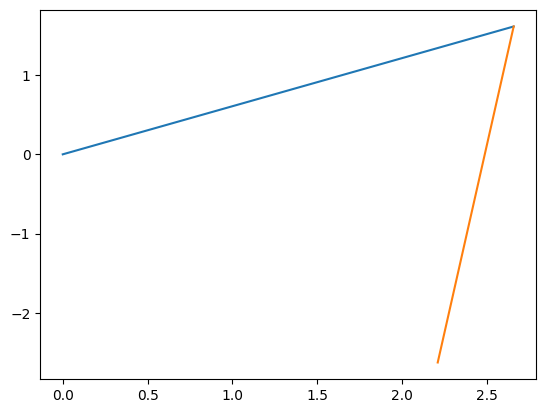

skip
117
0.19031730950183423


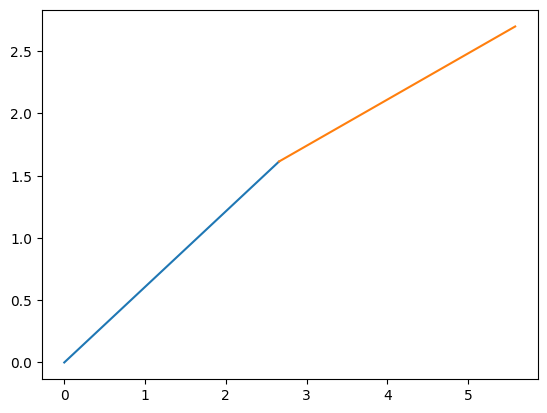

121
1.2514129034345558


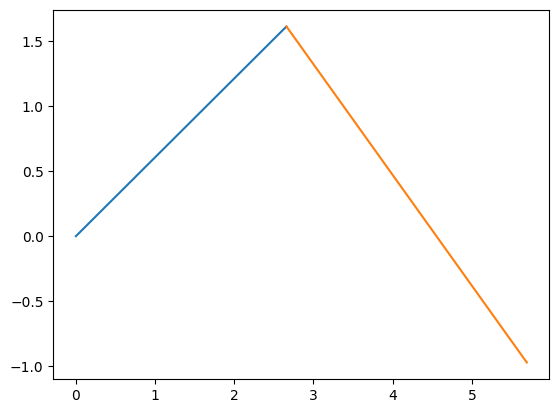

In [ ]:
from numpy import array, int32
from fsd_path_planning.sorting_cones.trace_sorter.end_configurations import neighbor_bool_mask_can_be_added_to_attempt

kwargs = {'trace': array([[ 5.24998999e+00, -1.96427393e+00],
       [ 8.84215736e+00,  2.25673532e+00],
       [ 7.56146049e+00, -1.63013148e+00],
       [ 1.31035566e+01, -2.82537913e+00],
       [ 1.56642532e+01, -3.78757524e+00],
       [ 1.08239489e+01, -2.04904604e+00],
       [ 5.60883284e+00,  2.07336545e+00],
       [ 1.71920242e+01,  5.78254986e+00],
       [ 1.99727669e+01, -4.19606781e+00],
       [ 1.38222733e+01,  2.48414934e-01],
       [ 1.28491764e+01, -1.05764141e+01],
       [ 1.91352654e+01, -3.66565377e-01],
       [ 1.92445240e+01,  1.94117987e+00],
       [ 9.54654694e+00,  7.09778643e+00],
       [ 1.49887848e+01, -1.26334457e+01],
       [ 1.65875359e+01, -2.66699851e-01],
       [ 2.14567261e+01, -7.49273777e-01],
       [ 2.17360497e+01,  7.90702915e+00],
       [ 2.41087933e+01, -7.37954259e-01],
       [ 2.36293297e+01, -4.24102831e+00],
       [ 2.63392735e+01, -1.62386417e+00],
       [ 2.85071239e+01, -2.75943351e+00],
       [ 3.12024212e+01, -4.57241392e+00],
       [ 2.59950447e+01, -5.03892136e+00],
       [ 2.85953522e+01, -6.80586910e+00],
       [ 3.30056152e+01, -6.27876425e+00],
       [ 3.40448418e+01, -8.68747997e+00],
       [ 3.48170700e+01, -1.10038109e+01],
       [ 3.51543808e+01, -1.39492702e+01],
       [ 3.15552139e+01, -1.08826218e+01],
       [ 3.19294872e+01, -1.39208908e+01],
       [ 3.39942398e+01, -1.64768944e+01],
       [ 4.60568047e+01, -6.20569658e+00],
       [ 3.75518723e+01, -3.45013022e+00],
       [ 3.19919605e+01, -1.97333298e+01],
       [ 3.66915894e+01, -1.96552391e+01],
       [ 2.89473076e+01, -2.15510635e+01],
       [ 3.67899933e+01, -3.10282784e+01],
       [ 2.59521427e+01, -2.18229198e+01],
       [ 2.21808891e+01, -2.19526157e+01],
       [ 2.24004421e+01, -3.37988510e+01],
       [ 1.65133781e+01, -2.42752857e+01],
       [ 1.45575504e+01, -2.25855865e+01],
       [ 1.94172230e+01, -2.11373882e+01],
       [ 1.74859104e+01, -2.63423882e+01],
       [ 1.77218113e+01, -2.87224293e+01],
       [ 2.52486038e+01, -1.86718464e+01],
       [ 1.69847126e+01, -1.94073009e+01],
       [ 1.34618511e+01, -2.64512672e+01],
       [ 1.22246485e+01, -2.48793201e+01],
       [ 2.29180260e+01, -1.83091583e+01],
       [ 1.72349529e+01, -3.12685795e+01],
       [ 9.99023628e+00, -2.36637478e+01],
       [ 1.40364447e+01, -3.09607449e+01],
       [ 1.16938143e+01, -2.06828461e+01],
       [ 1.27412958e+01, -1.55280828e+01],
       [ 2.09443703e+01, -1.77957821e+01],
       [ 1.91252899e+01, -1.65926991e+01],
       [ 1.58568354e+01, -3.43096581e+01],
       [ 1.68182774e+01, -1.48912039e+01],
       [ 7.12906170e+00, -1.44847651e+01],
       [ 7.70924187e+00, -1.76631489e+01],
       [ 1.49654255e+01, -1.75512772e+01],
       [ 9.20312119e+00, -1.90085430e+01],
       [ 1.05752525e+01, -1.37777615e+01],
       [ 3.86605406e+00, -1.91585121e+01],
       [ 7.32273006e+00, -2.22118816e+01],
       [ 5.45412683e+00, -2.09617195e+01],
       [ 8.21805954e+00, -1.04652719e+01],
       [ 4.59324551e+00, -7.61188889e+00],
       [ 5.32540083e+00, -1.09959221e+01],
       [ 1.05118866e+01, -1.02859154e+01],
       [ 2.94967246e+00, -1.67309284e+01],
       [ 2.80443645e+00, -1.44466438e+01],
       [ 3.43911505e+00, -1.22703066e+01],
       [ 2.70754981e+00, -2.85197306e+00],
       [-1.00482023e+00, -2.57357860e+00],
       [ 1.51108764e-02,  1.48188567e+00],
       [-6.49416351e+00, -1.71949120e+01],
       [-9.16453648e+00, -1.60541782e+01],
       [-3.92450762e+00, -1.91654015e+01],
       [-1.13307228e+01, -1.50868511e+01],
       [-5.99858570e+00, -2.30699520e+01],
       [-3.51369888e-01, -2.38673782e+01],
       [-2.60822988e+00, -2.13558979e+01],
       [-1.01632862e+01, -1.91909561e+01],
       [-7.70231056e+00, -2.05936470e+01],
       [-1.71859276e+00, -2.69259930e+01],
       [-4.23611784e+00, -2.52540436e+01],
       [ 5.56876123e-01, -2.83745651e+01],
       [ 1.91967988e+00, -3.02260742e+01],
       [ 4.80219698e+00, -2.72482243e+01],
       [ 8.06902981e+00, -3.29324112e+01],
       [ 2.37536669e+00, -2.52801018e+01],
       [ 3.75212598e+00, -3.27804184e+01],
       [ 5.24691200e+00, -3.46549530e+01],
       [ 6.67501736e+00, -3.02656994e+01],
       [ 1.04188986e+01, -3.39253426e+01],
       [ 1.40154324e+01, -2.86715508e+01],
       [ 1.01377478e+01, -3.66146088e+01],
       [ 1.28654976e+01, -3.27520027e+01],
       [ 1.27361288e+01, -3.62279663e+01],
       [ 7.39302588e+00, -3.61646805e+01],
       [-4.74734449e+00, -3.86279907e+01],
       [-1.23856516e+01, -1.81305733e+01],
       [-1.45530825e+01, -1.66566811e+01],
       [-1.65173855e+01, -1.46627150e+01],
       [-1.71762428e+01, -7.89923620e+00],
       [-1.14323492e+01, -3.76584673e+00],
       [-1.42657290e+01, -1.01028118e+01],
       [-1.36824598e+01, -1.29168978e+01],
       [-1.76708412e+01, -1.13803205e+01],
       [-1.36739407e+01, -6.46305943e+00],
       [-1.36433010e+01, -1.13773978e+00],
       [-2.46186066e+01, -4.34011936e+00],
       [-2.23307724e+01, -3.35033369e+00],
       [-1.09844847e+01,  4.76479143e-01],
       [-8.06238079e+00,  1.56078374e+00],
       [-2.45875187e+01,  9.95069790e+00],
       [-5.25394154e+00,  2.18047857e+00],
       [-9.06100082e+00,  1.22967548e+01],
       [-7.94955015e+00, -2.10991883e+00],
       [-2.48476839e+00,  2.03034091e+00],
       [-5.57333040e+00, -1.55212784e+00],
       [ 3.07594895e+00,  4.62680197e+00],
       [ 3.69403038e+01,  2.92362595e+00],
       [ 4.39627838e+01, -2.92147851e+00],
       [-1.13547325e+01, -7.75516939e+00],
       [-1.38213301e+01, -2.70202656e+01],
       [-3.06868267e+01, -1.15252895e+01],
       [-1.88980637e+01,  7.67844009e+00],
       [-1.56308346e+01,  7.14929295e+00]]), 'cone_type': ConeTypes.BLUE, 'current_attempt': array([113, 116,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1], dtype=int32), 'position_in_stack': 1, 'neighbors': array([108, 113, 117, 121]), 'threshold_directional_angle': 0.6981317007977318, 'threshold_absolute_angle': 0.9599310885968813, 'car_position': array([-13.87806292,  -4.73805429]), 'car_direction': array([0.5077767 , 0.86148872]), 'car_size': 2.1}

def angle_difference(angle1: np.ndarray, angle2: np.ndarray) -> np.ndarray:
    """
    Calculate the difference between two angles. The range of the difference is [-pi, pi].
    The order of the angles *is* important.

    Args:
        angle1: First angle.
        angle2: Second angle.

    Returns:
        The difference between the two angles.
    """
    return (angle1 - angle2 + 3 * np.pi) % (2 * np.pi) - np.pi 

c = kwargs['trace']
att = kwargs['current_attempt']
att = att[att != -1]
nei = kwargs['neighbors']
pis = kwargs['position_in_stack']

# plt.plot(c[:,0], c[:,1], 'k.')
# plt.plot(c[att,0], c[att,1], 'r.')
# plt.plot(c[nei,0], c[nei,1], 'b.')

# neighbor_bool_mask_can_be_added_to_attempt(**kwargs)
for i in range(len(nei)):
    
    if nei[i] in att:
        print('skip')
        continue
    
    print(nei[i])
    candidate_neighbor = c[nei[i]]
    second_to_last_in_attempt = c[att[pis - 1]]
    last_in_attempt = c[att[pis]]
    second_to_last_to_last = last_in_attempt - second_to_last_in_attempt
    last_to_candidate = candidate_neighbor - last_in_attempt

    m = second_to_last_to_last + last_to_candidate
    plt.plot([0, second_to_last_to_last[0]], [0, second_to_last_to_last[1]], '-')
    plt.plot([second_to_last_to_last[0], m[0]], [second_to_last_to_last[1], m[1]], '-')


    angle_1 = np.arctan2(second_to_last_to_last[1], second_to_last_to_last[0])
    angle_2 = np.arctan2(last_to_candidate[1], last_to_candidate[0])
    diff = angle_difference(angle_1, angle_2)
    print(diff)
    plt.show()
    # print(angle_1, angle_2, angle_2 - angle_1)
    

In [ ]:
import rosbag

bag = rosbag.Bag('/mnt/c/Users/papal/Downloads/2022-10-12-14-55-06.bag')

In [ ]:
odoms = []
clusters = []

for topic, msg, t in bag.read_messages(topics=['/Odometry', "/slam/accumulated_clusters"]):
    if topic == "/Odometry":
        odoms.append(msg)
    elif topic == "/slam/accumulated_clusters":
        clusters.append(msg)

In [ ]:
from fsd_path_planning.utils.math_utils import quaternion_to_euler_angles, unit_2d_vector_from_angle

def odometry_to_yaw(msg) -> None:

    position_xy = np.array(
        [
            msg.pose.pose.position.x,
            
            msg.pose.pose.position.y,
        ]
    )
    q = msg.pose.pose.orientation
    yaw = quaternion_to_euler_angles(np.array([q.x, q.y, q.z, q.w]))[2]

    direction_xy = unit_2d_vector_from_angle(yaw)

    return position_xy, direction_xy

In [ ]:
len(clusters), len(odoms)

(2036, 2042)

(-34.630396938323976,
 52.12814817428589,
 -48.876010274887086,
 17.84210810661316)

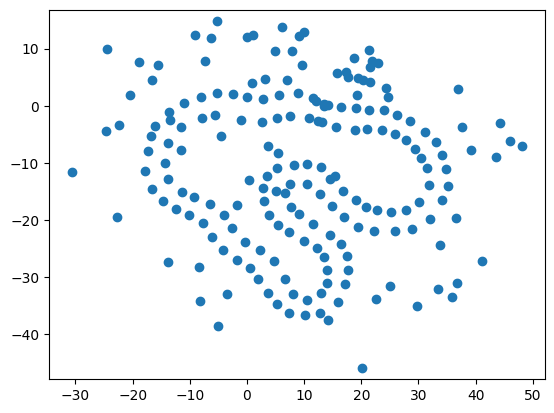

In [ ]:
from chabo_common.utils.parsing import pointcloud2_XYZI_to_array
from fsd_path_planning.utils.cone_types import ConeTypes

from sklearn.cluster import DBSCAN

def filter_clusters(clusters):
    return clusters
    model = DBSCAN(eps=2, min_samples=1).fit(clusters)

    out = []

    for l in set(model.labels_):
        mask = model.labels_ == l
        
        points_in_cluster = clusters[mask]

        if len(points_in_cluster) > 3:
            continue

        median = np.median(points_in_cluster, axis=0)

        out.append(median)

    return np.array(out)



def convert_pointscloud_to_cones_arrays(pc):
    array = pointcloud2_XYZI_to_array(pc)

    cones = [np.zeros((0,2)) for _ in ConeTypes]

    clusters = filter_clusters(array[:, :2])

    i = np.linalg.norm(clusters, axis=1).argsort()[1]
    mask_keep = np.ones(len(clusters), dtype=bool)
    mask_keep[i] = False

    clusters = clusters[mask_keep]

    cones[ConeTypes.UNKNOWN] = clusters

    return cones


x = convert_pointscloud_to_cones_arrays(clusters[-1])
plt.plot(*x[0].T, 'o')

# i = np.linalg.norm(x[0], axis=1).argsort()[1]
# print(i)
# plt.plot(*x[0][i], 'o', color='red')

plt.axis("equal")

In [ ]:
print(len(clusters), len(odoms))

2036 2042


In [ ]:

o = []

for odom, cluster in zip(odoms, clusters):
    cones = convert_pointscloud_to_cones_arrays(cluster)
    position, direction = odometry_to_yaw(odom)
    
    d = {
        "car_position": position.tolist(),
        "car_direction": direction.tolist(),
        "slam_cones": [x.tolist() for x in cones]
    }

    o.append(d)


    

In [ ]:
# idx_dist_change_start = 0

# for 

In [ ]:
import json
from pathlib import Path

Path('/home/papalotis/repos/fsd-path-planning/fsd_path_planning/demo/october_gatow_3.json').write_text(json.dumps(o[100:]))

12384599